# model_deploy


## Visualizando a evolução do número de reprodução no Brasil

Vamos reproduzir o [modelo do Kevin Systrom](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) para estimarmos $R_t$, o número de reprodução eficaz, para os estados brasileiros.

Começamos importando as bibliotecas necessárias. Condensamos boa parte do código no script `core.py`, para facilitar a utilização desse notebook.

In [1]:
# importing core 
# aqui empacotamos as funções que dá pra achar no código do Kevin Systrom
from core import run_full_model, load_data, plot_rt, plot_standings

# imports básicos
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# importando joblib para rodar em paralelo
from joblib import Parallel, delayed

# para plots com uma melhor resolução
%config InlineBackend.figure_format = 'retina'


Bad key "axes.titlelocation" on line 298 in
/Users/guilherme.marmerola/Documents/Repositories/realtime_r0/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Área reservada para parâmetros do modelo. Até agora só deixamos aberto `N_JOBS`, para escolher o número de núvleos para o ajuste dos modelos.

In [2]:
### parâmetros ###

# númreo de cores para paralelizar modelo nos estados
N_JOBS = -1

### Leitura dos dados

Usamos o [repositório do Wesley Cota](https://github.com/wcota/covid19br) para pegar os dados mais atualizados por estado. 

In [3]:
### reading data ###

# lendo do repositório do Wesley Cota
city_df, state_df = load_data()

# para a análise, vamos usar somente novos casos confirmados
city_df = city_df['confirmed_new']
state_df = state_df['confirmed_new']

In [4]:
# última data
print('Última data:', state_df.index.max()[1])

Última data: 2020-04-24 00:00:00


### Ajuste do modelo

Ajustamos um modelo bayesiano simples, assumindo que os dados de novos casos assumem uma distribuição Poisson parametrizada por $\lambda$ e a seguinte fórmula para a conexão entre $R_t$ e $\lambda$ ([segundo este artigo](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185)):

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

onde $\gamma$ é a recíproca do *serial interval* ([em torno de 7 dias para o COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)) e $k_{t-1}$ é o número de novos casos para o dia anterior. Abaixo rodamos a função `run_full_model` para todos os estados em paralelo. Mais detalhes no [notebook do Kevin](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).

In [5]:
### running posteriors ###

with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.01) for grp in state_df.groupby(level='state'))

final_results = pd.concat(results)

### Observando os resultados: $R_t$

Usamos o mesmo padrão de visualização adotado pelo Kevin. Nos gráficos, cada ponto é a estimativa de $R_t$ para o dia, e a área cinzenta indica o intervalo crível de 90% de probabilidade. Deixamos $R = 1$ em evidência, já que quando $R_t < 1$ indica que a epidemia está sob controle.

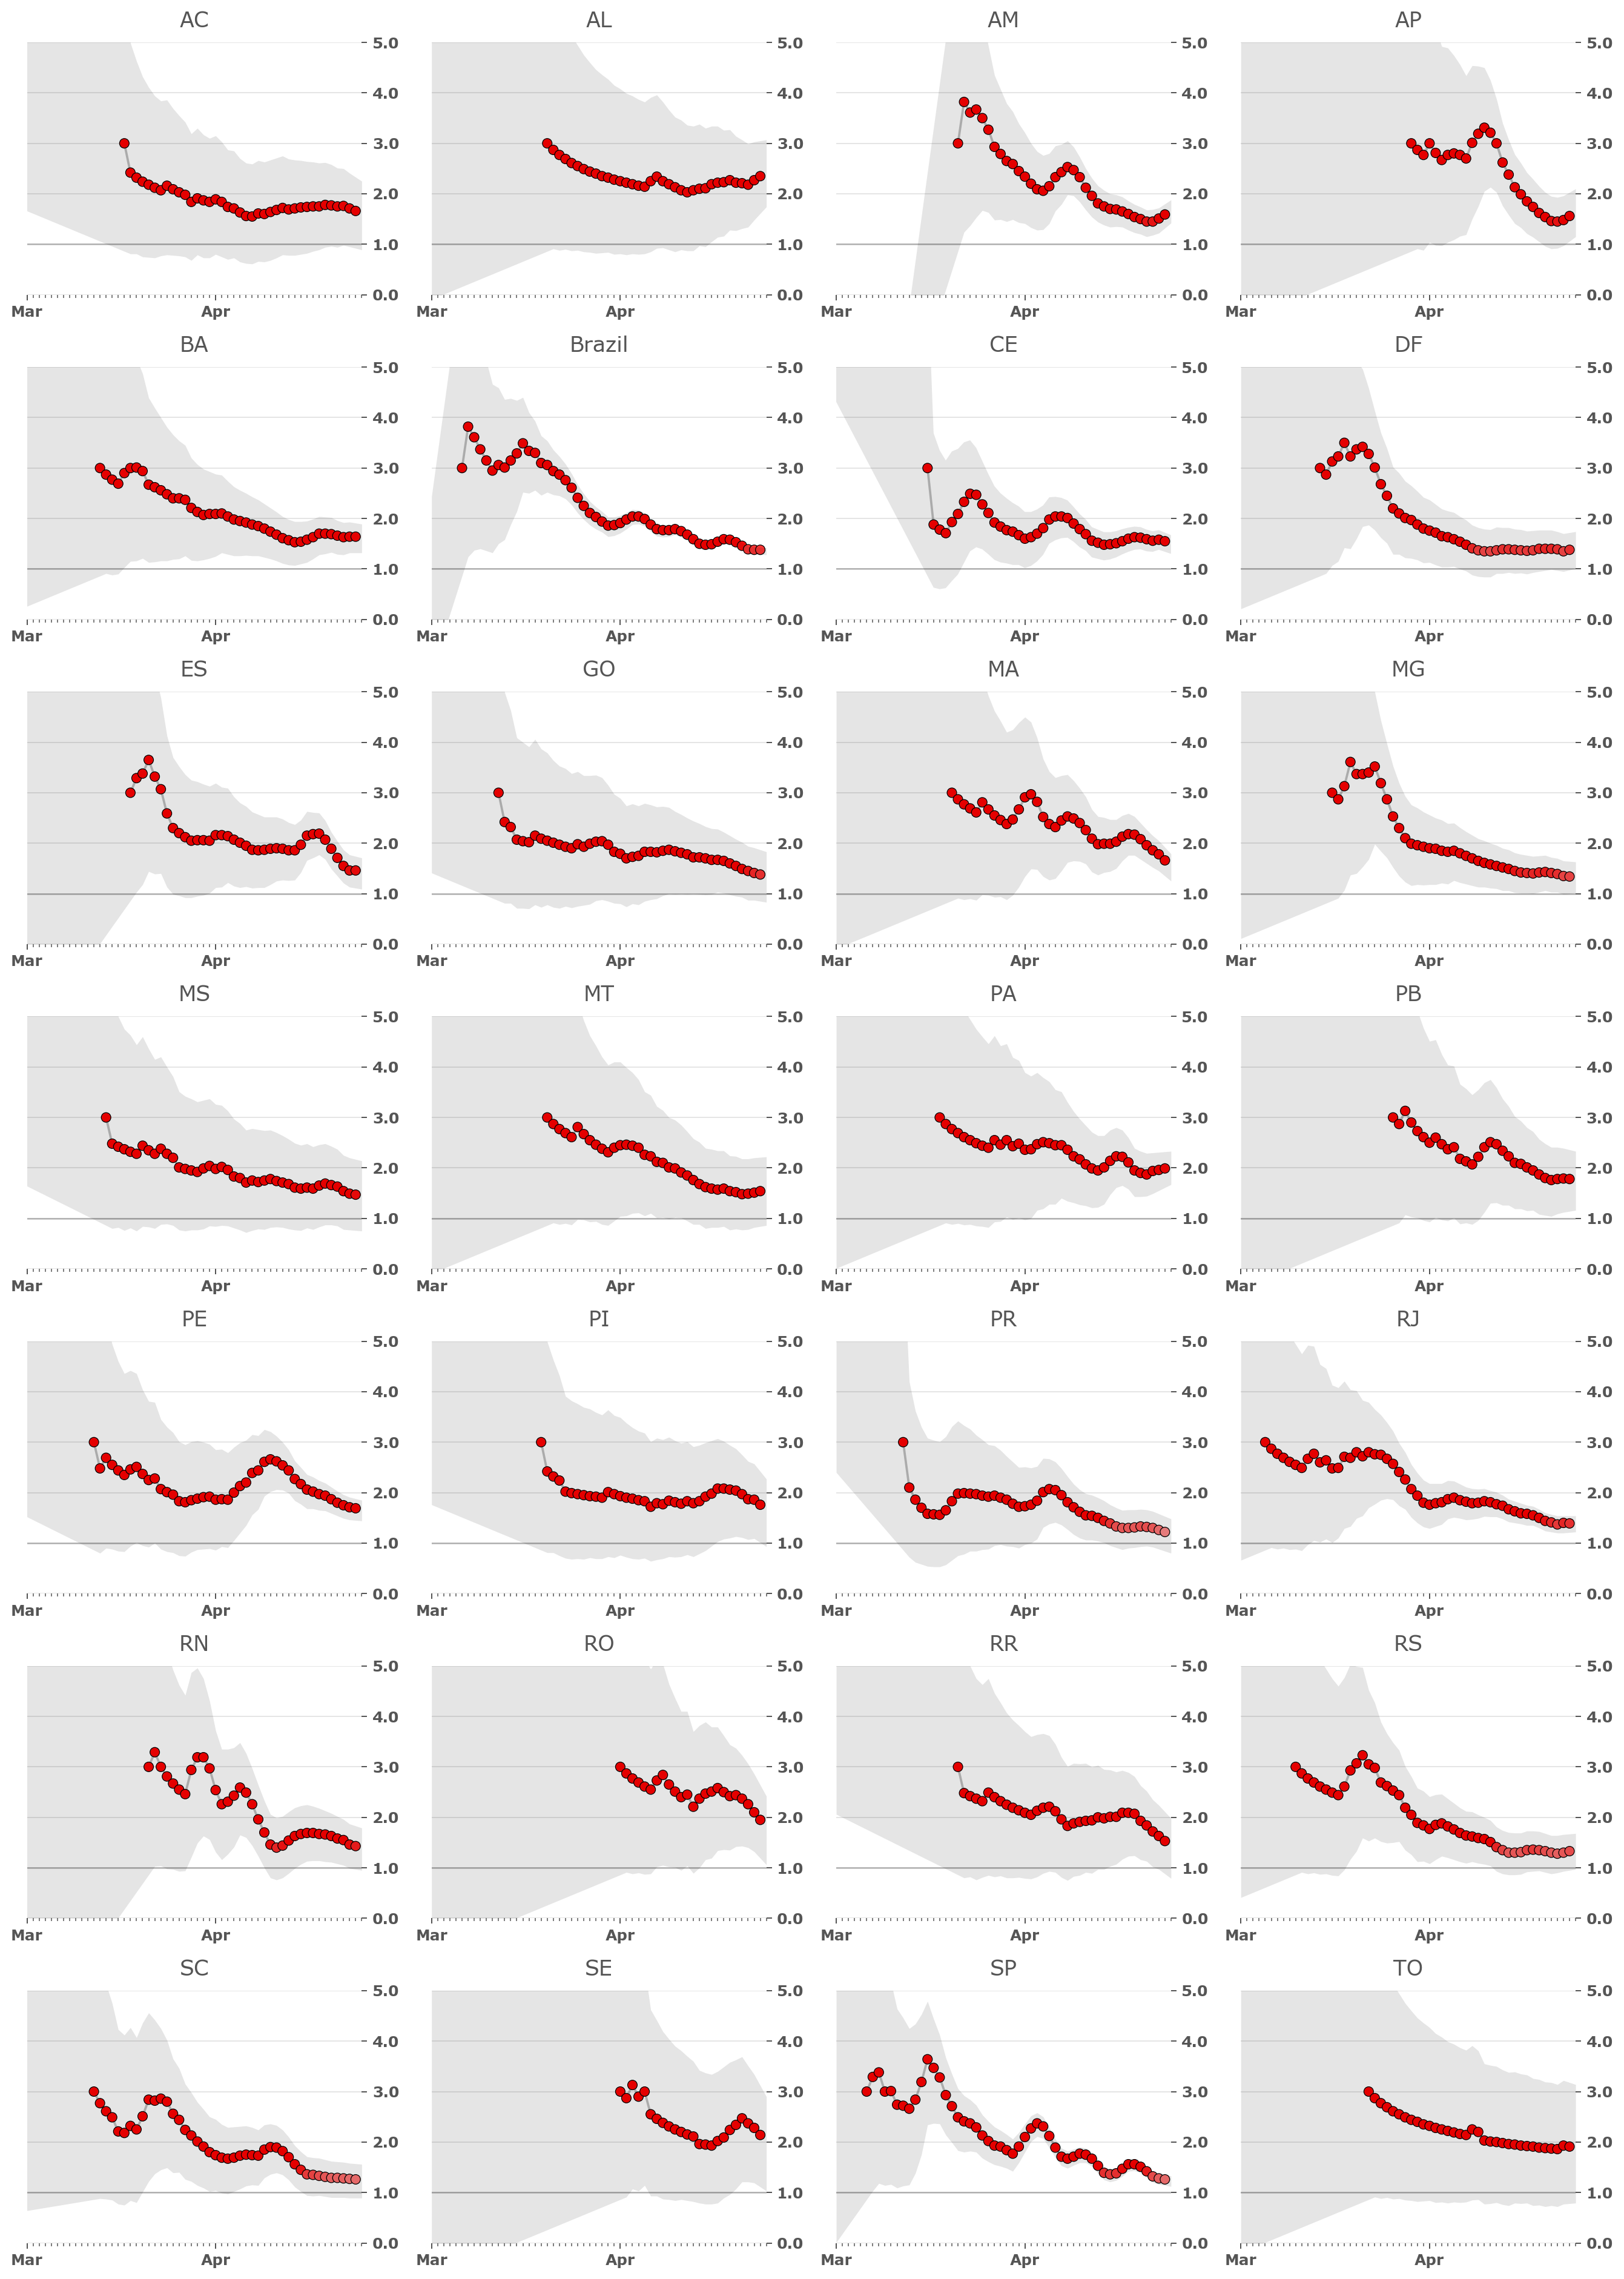

In [6]:
### plotting - Rt vs time for all states ###

def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()

### Observando os resultados: comparação entre estados

Para fazer uma comparação entre estados, mostramos a última estimativa de $R_t$ de cada estado no gráfico de barras a seguir, com a incerteza associada. Os gráficos estão ordenados do melhor para o pior usando a estimativa mais provável do modelo.

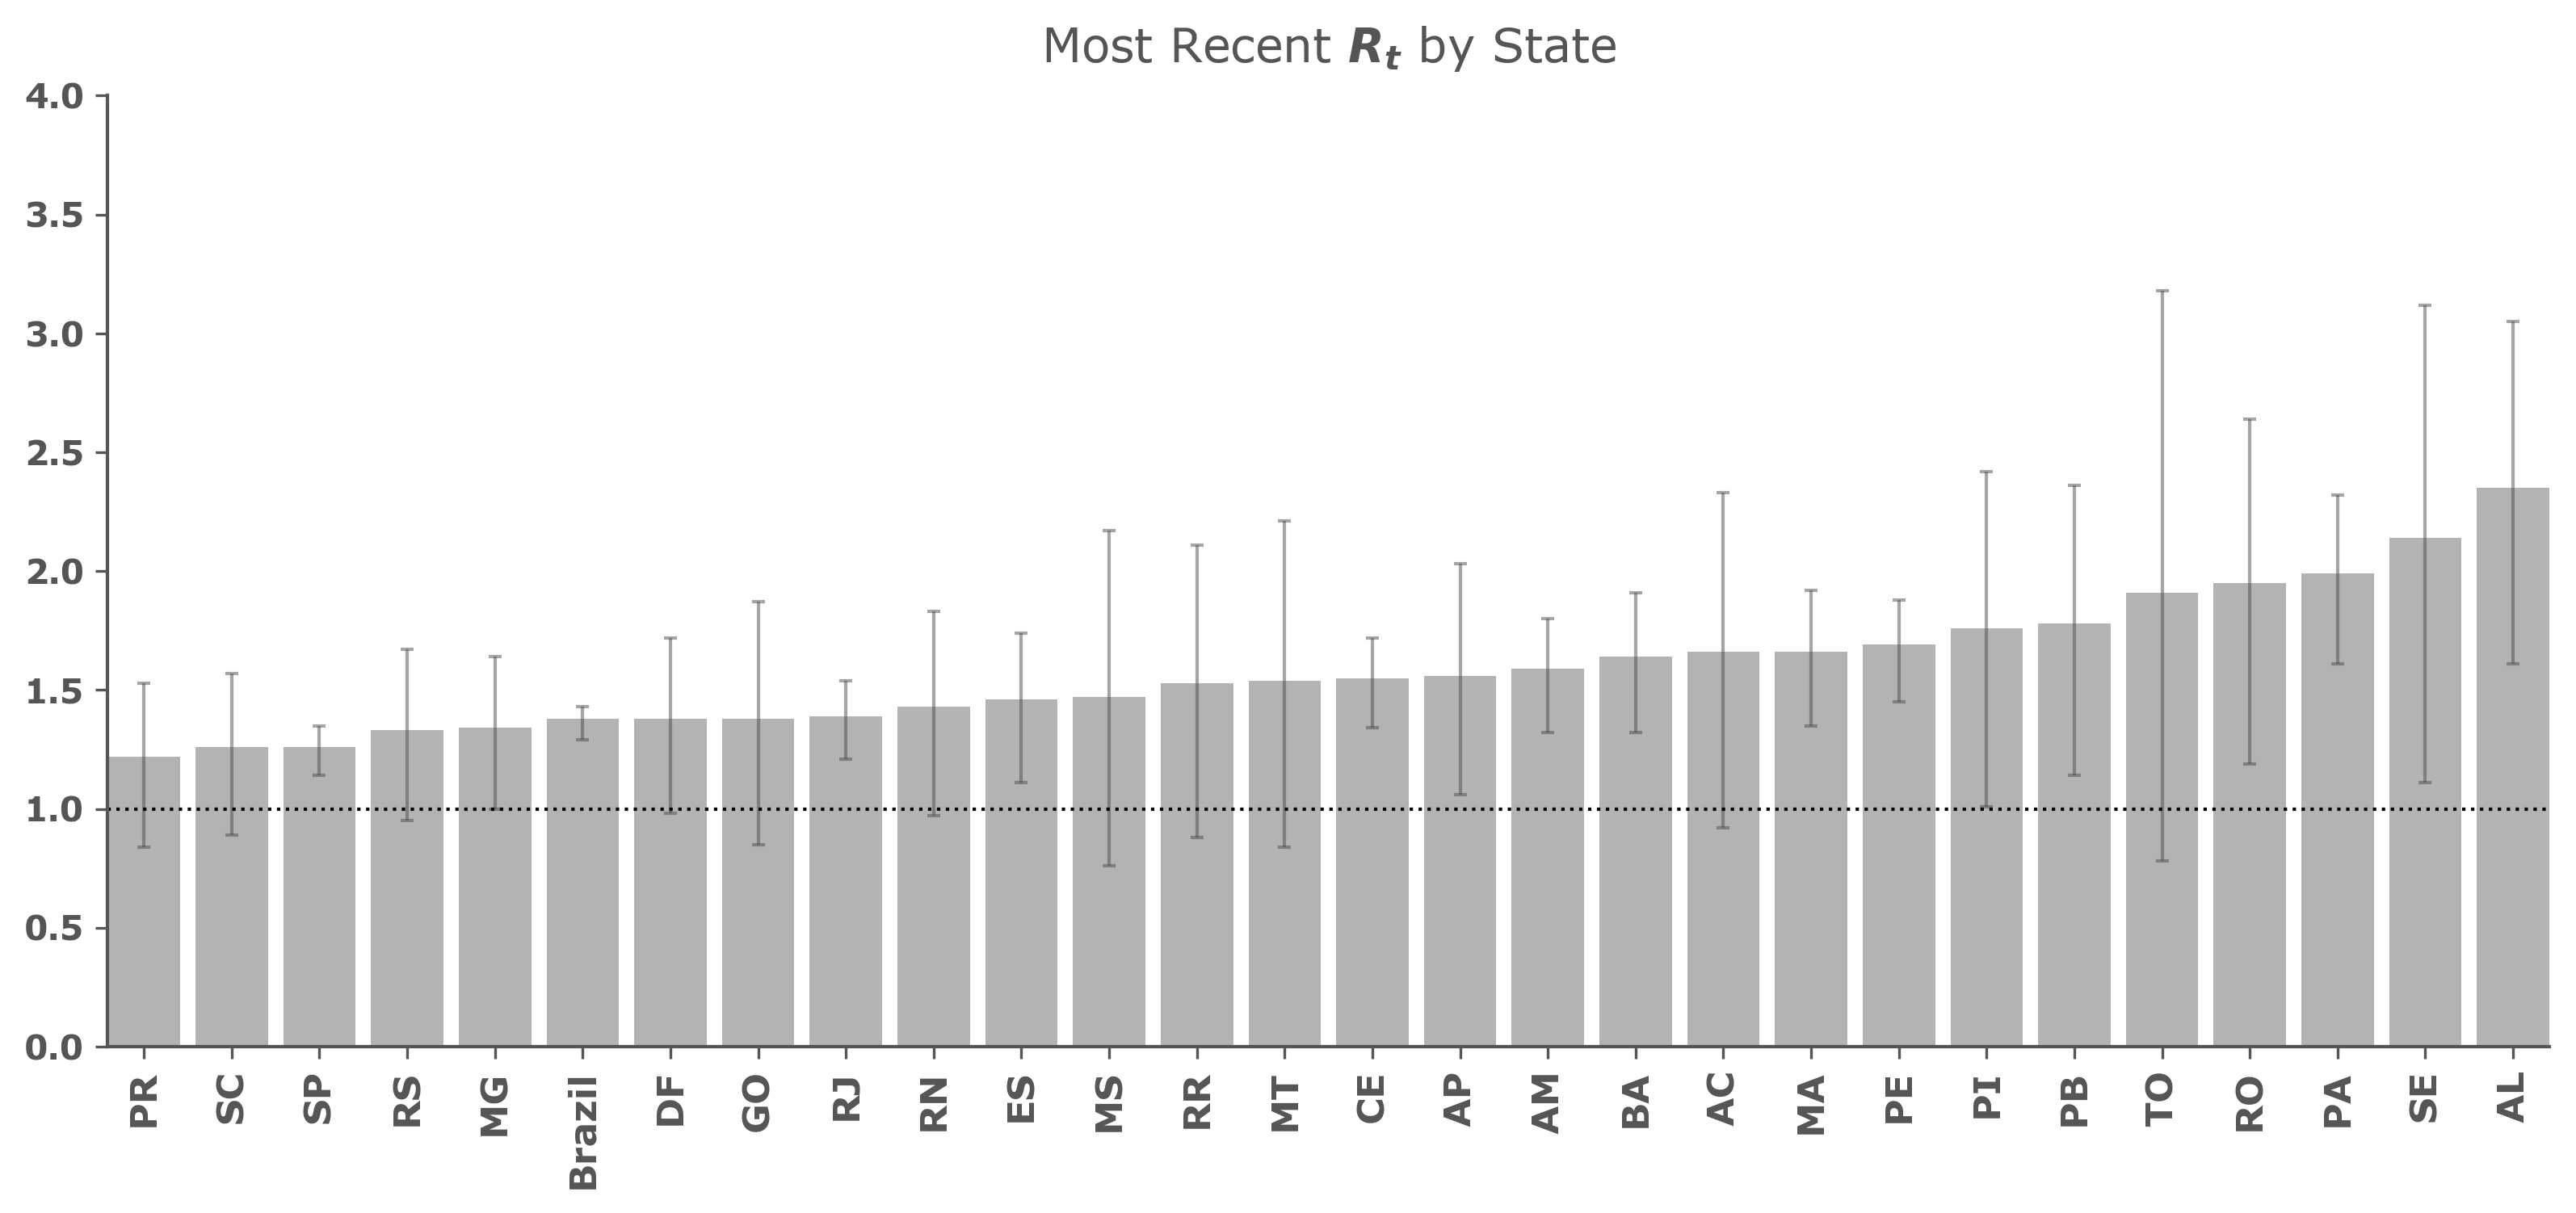

In [7]:
### plotting - state comparison ###

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(13,5));

Podemos ordenar também pelo pior caso possível também, usando nossas estimativas de incerteza:

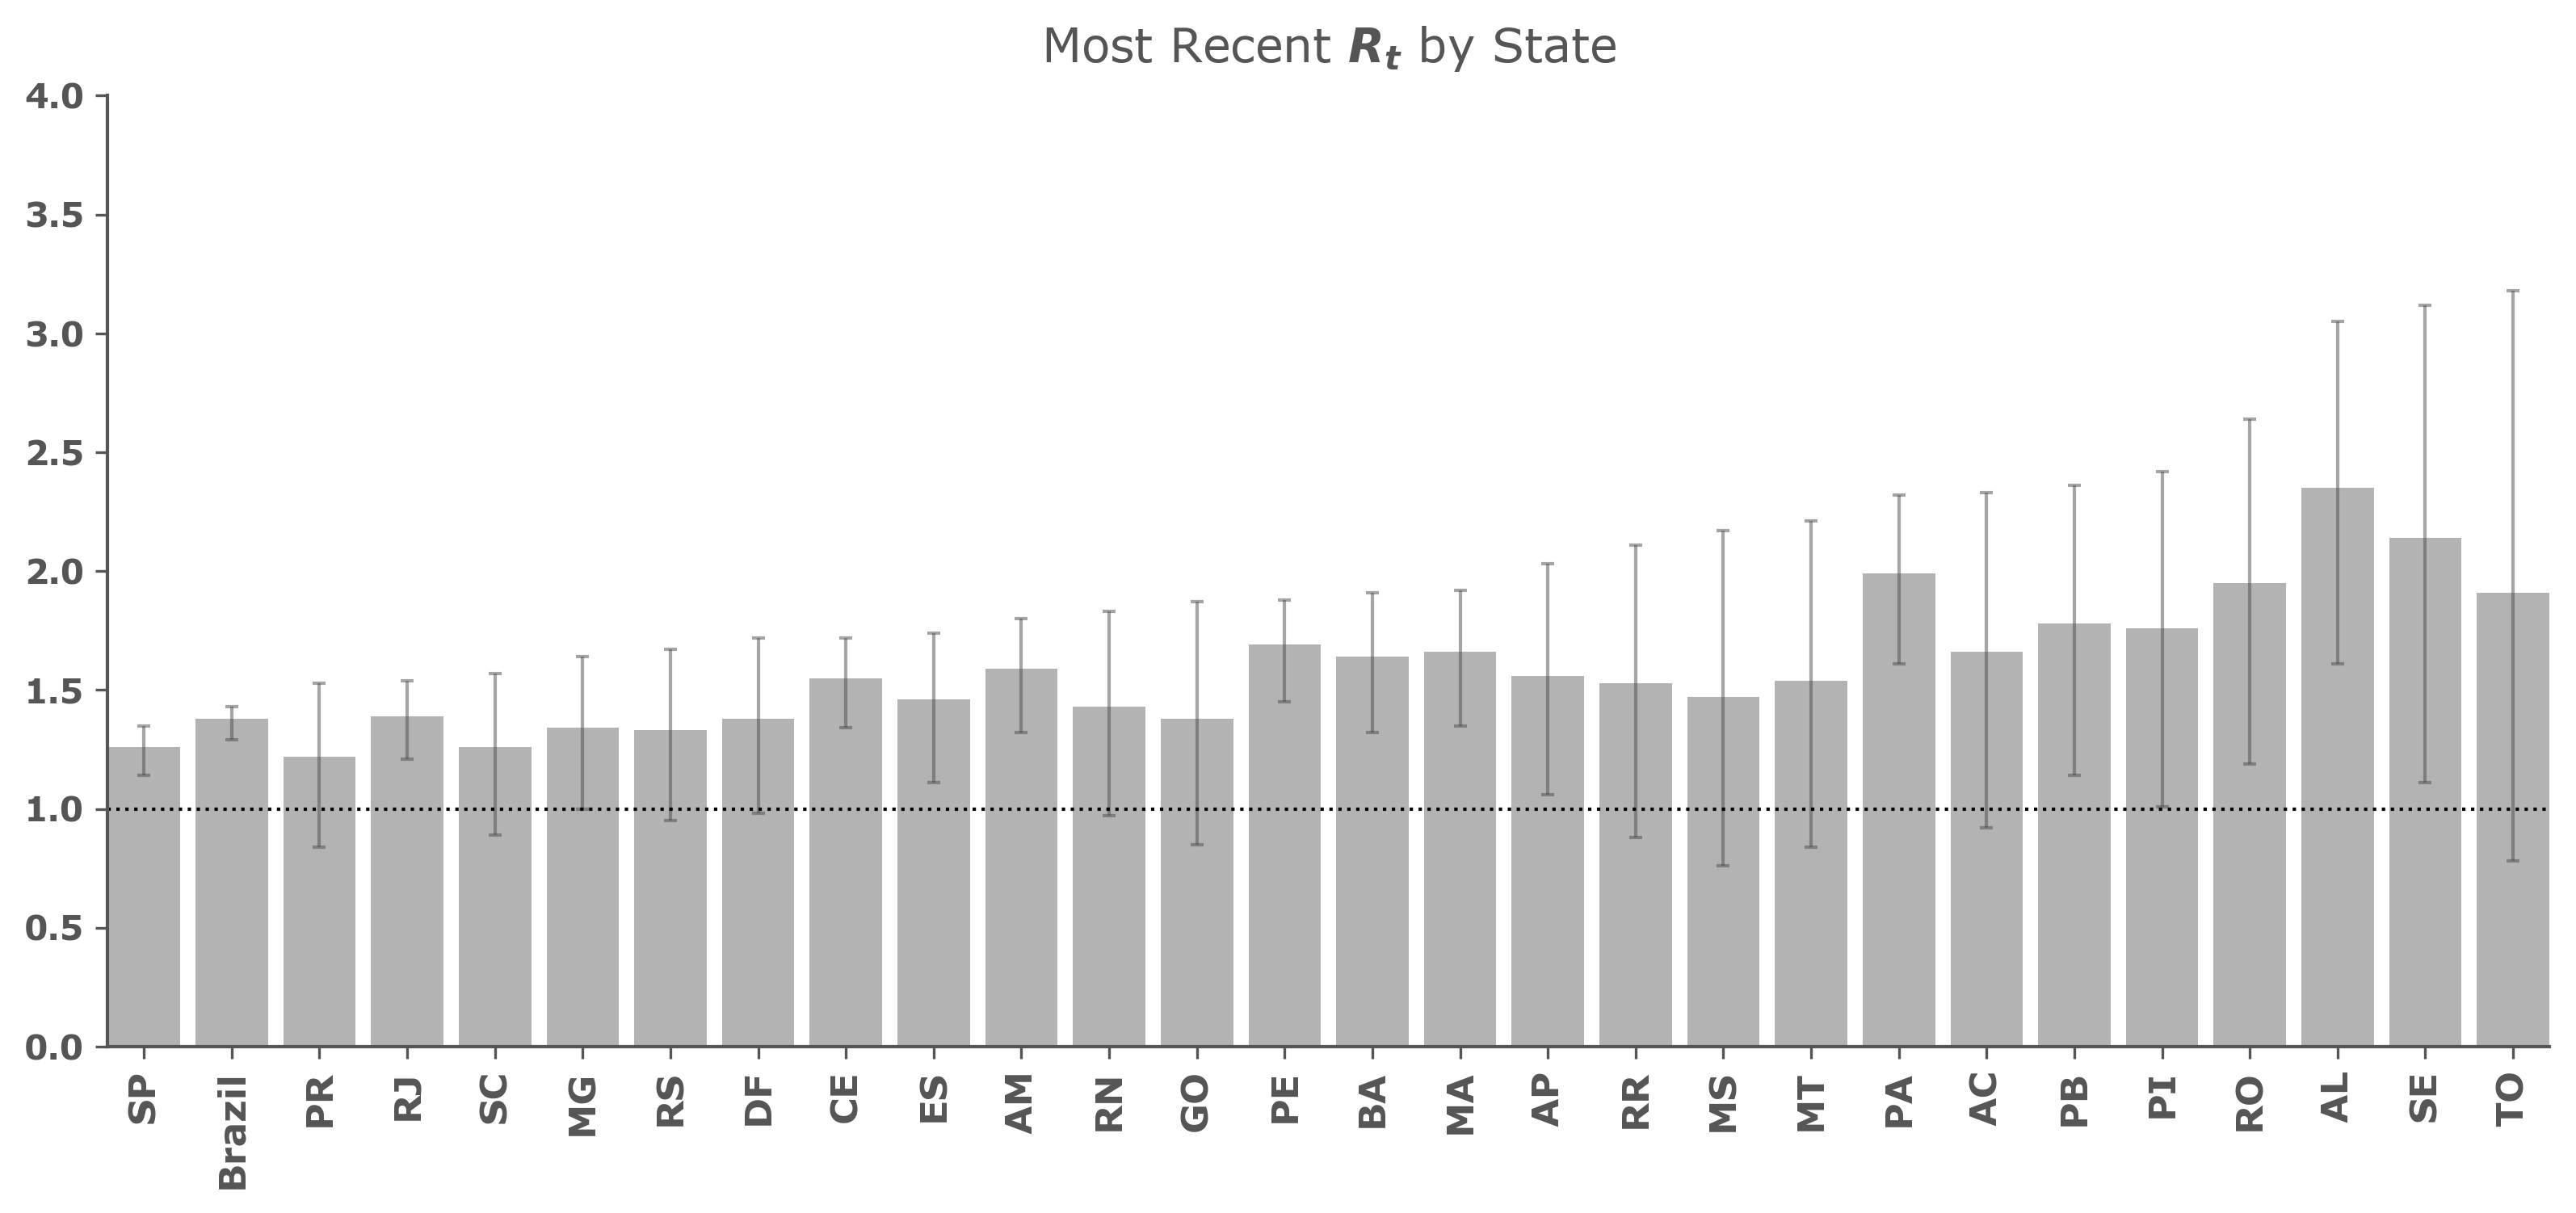

In [8]:
### ordering by worst case ##

mr.sort_values('High_90', inplace=True)
plot_standings(mr, figsize=(13,5));

In [9]:
final_results.reset_index().to_csv('./model_results.csv', index=False)

In [10]:
!git add model_results.csv

In [11]:
!git commit -m "data update"

[master c206c0e] data update
 1 file changed, 35 insertions(+), 7 deletions(-)


In [12]:
!git push heroku master

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 12 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 973 bytes | 973.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Compressing source files... done.
remote: Building source:
remote: 
remote: -----> Python app detected
remote: -----> No change in requirements detected, installing from cache
remote: -----> Installing SQLite3
remote: -----> Installing requirements with pip
remote: -----> Discovering process types
remote:        Procfile declares types -> web
remote: 
remote: -----> Compressing...
remote:        Done: 128.1M
remote: -----> Launching...
remote:        Released v20
remote:        https://realtime-r0-covid-brazil.herokuapp.com/ deployed to Heroku
remote: 
remote: Verifying deploy... done.
To https://git.heroku.com/realtime-r0-covid-brazil.git
   f0ede02..c206c0e  master -> master


Text(0.5, 1.0, 'Real-time $R_t$ for SC')

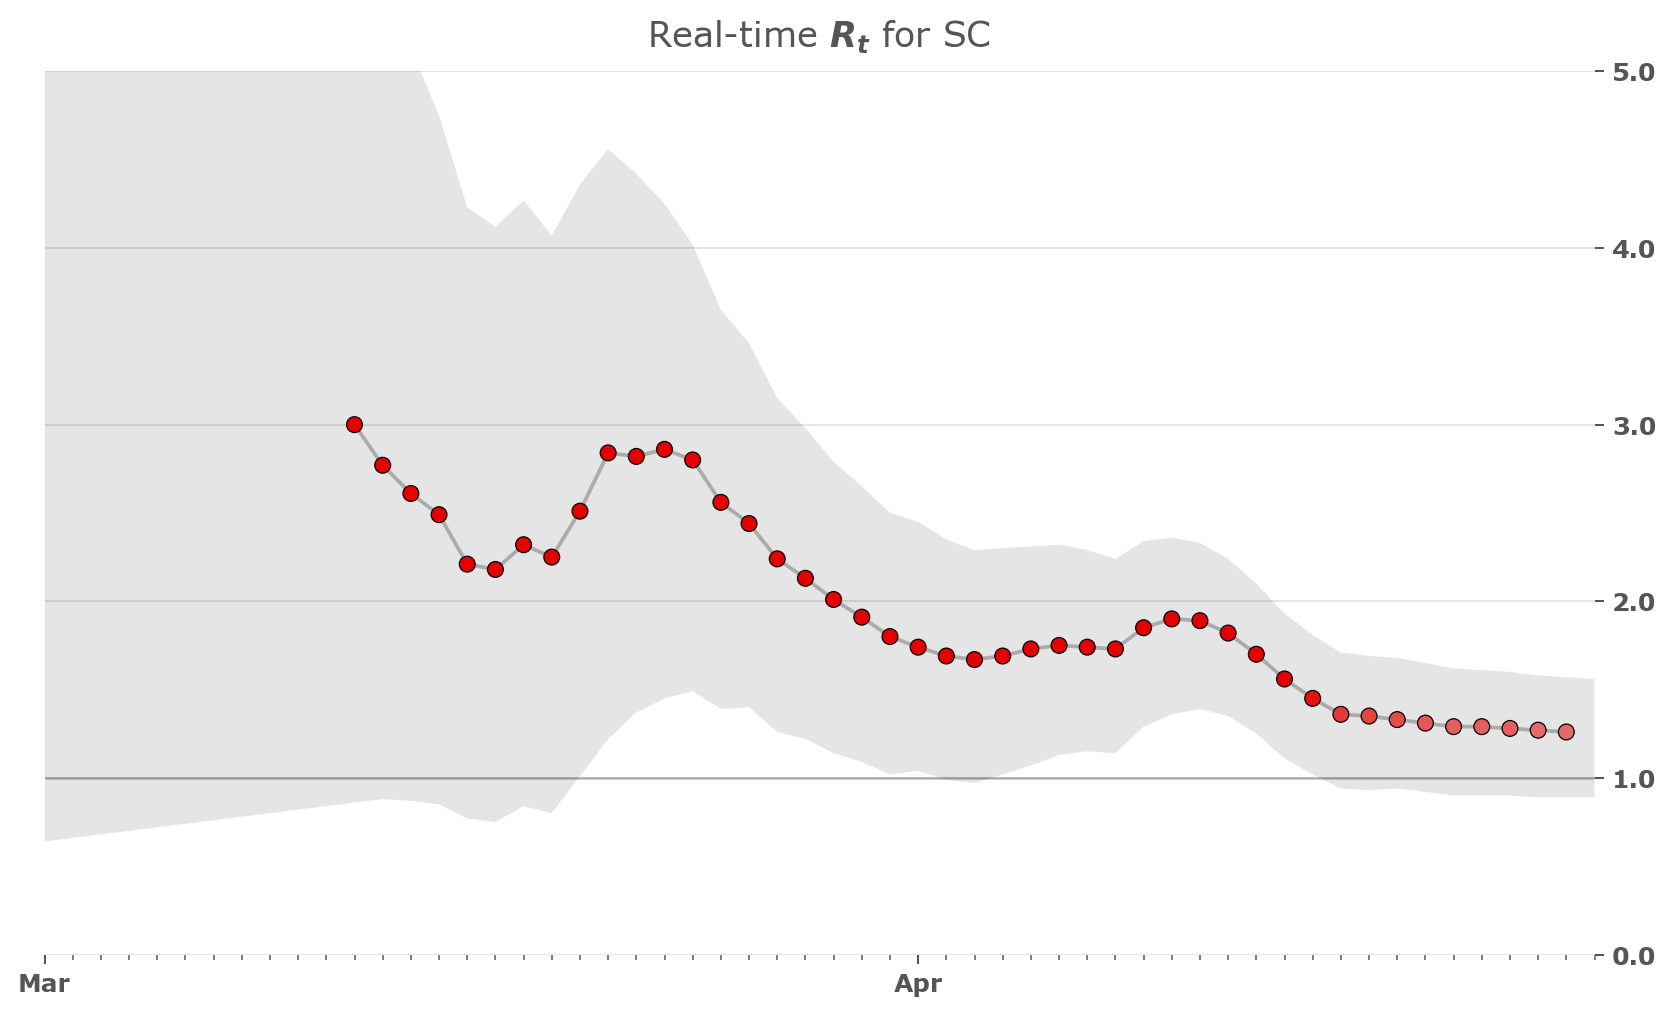

In [13]:
state_name = 'SC'
series = state_df.loc[lambda x: x.index.get_level_values(0) == state_name]

result = run_full_model(series, sigma=0.01)

fig, ax = plt.subplots(figsize=(800/72,450/72), dpi=90)

plot_rt(result, ax, state_name)
fig.set_facecolor('w') 
ax.set_title(f'Real-time $R_t$ for {state_name}')